In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import odeint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Input, Activation, Dropout
from keras import backend as K
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf
from keras.models import Model
from keras.models import load_model
import time #to calculate the computation time

# Check the prediction performance of FP model using condition 4

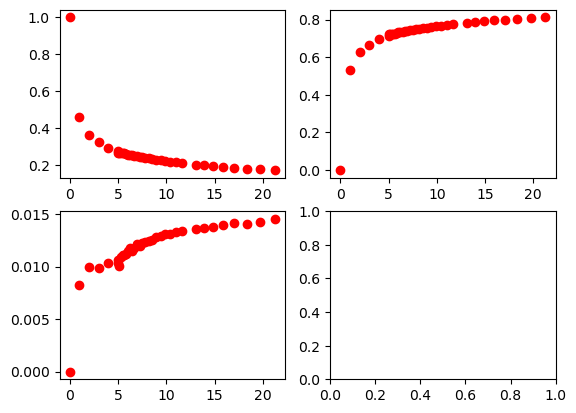

In [2]:
# extracting y_actual data
raw_input = pd.read_excel('Updated_photochemical_Experiment.xlsx','Sheet4')

X=raw_input.values.astype(np.float64)
X1 = X[:,2]
Y1 = X[:,10]
Y2 = X[:,11]
Y3 = X[:,9]
fig, ax = plt.subplots(2, 2)
ax[0,0].scatter(X1,Y1, color='r')
ax[0,1].scatter(X1,Y2, color='r')
ax[1,0].scatter(X1,Y3, color='r')
plt.show()

In [3]:
print(X1)

X1 = [round(X1[i], 2) for i in range(len(X1))]
print(X1)
1 in X1

[ 0.          1.          2.          3.          4.          5.
  5.03586213  5.14649097  5.30111004  5.4649041   5.63867566  5.82331844
  6.01982984  6.22932528  6.4530548   6.69242217  6.94900701  7.22459021
  7.5211832   7.84106147  8.18680287  8.56133087  8.96796312  9.41046508
  9.89310801 10.42072996 10.99879691 11.63345974 13.1008564  13.94961458
 14.88695124 15.92250695 17.06627394 18.32828423 19.71819689 21.24480099]
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 5.04, 5.15, 5.3, 5.46, 5.64, 5.82, 6.02, 6.23, 6.45, 6.69, 6.95, 7.22, 7.52, 7.84, 8.19, 8.56, 8.97, 9.41, 9.89, 10.42, 11.0, 11.63, 13.1, 13.95, 14.89, 15.92, 17.07, 18.33, 19.72, 21.24]


True

In [4]:
# define parameters

R = (6.4*10e-3)/2 # m
phi = 1.11 #0.21
qp_480 = 1.3 * 10e-4 # moles photons · m-2 · s-1
Vr = 4.78 * 10e-6 # m3
KA = 11000*10e2*10e-3 # M-1∙m-1
alpha = 11000*10e2*10e-3 # M-1∙m-1

# Check
print(KA)

# 240 W
qp_240 = qp_480*240/480

#120 W
qp_120 = qp_480*120/480

print(qp_240)
print(qp_120)
print(qp_480)

110000.0
0.0006500000000000001
0.00032500000000000004
0.0013000000000000002


In [5]:
# parameter to be optimized
phi_n1 = 4.61229427e-01
mpc1 = 1.00000000e-01
ka1 = 8.61556978e-01
kc1 = 1.00000000e+02
k11 = 9.78273754e+00
k21 = 6.63580987e-02


In [6]:
def CSimulation(CAo,qp): 
    
    CA = 1
    CC = 0
    CE = 0
    CB = 0.4
    
    CA_list = list()
    CC_list = list()
    CE_list = list()
    
    t_step = 0.01
    
    for i in range(2200):
        
        dCAndtau = -((phi_n1/CAo)*(qp/Vr)*(ka1*CA*CAo/(mpc1+ka1*CA*CAo+kc1*CC*CAo))*
                     (1-np.exp(-(mpc1+ka1*CA*CAo+kc1*CC*CAo)*2*R))) 
        
        dCCndtau = ((k11*CB)/(k11+k21)**1)*((1/CAo)*(qp/Vr)*(ka1*CA*CAo/(mpc1+ka1*CA*CAo+kc1*CC*CAo))*
                                            (1-np.exp(-(mpc1+ka1*CA*CAo+kc1*CC*CAo)*2*R)))**1   
        
        dCEndtau = (k21/(k11+k21)**1)*((1/CAo)*(qp/Vr)*(ka1*CA*CAo/(mpc1+ka1*CA*CAo+kc1*CC*CAo))*
                                       (1-np.exp(-(mpc1+ka1*CA*CAo+kc1*CC*CAo)*2*R)))**1   
    
        
        CA += dCAndtau * t_step
        CC += dCCndtau * t_step
        CE += dCEndtau * t_step
        if round(i*t_step, 2) in X1:
            CA_list.append(CA) 
            CC_list.append(CC)  
            CE_list.append(CE)  
        

    return [CA_list,CC_list,CE_list]

In [7]:
CA_list,CC_list,CE_list = CSimulation(0.3,qp_480)

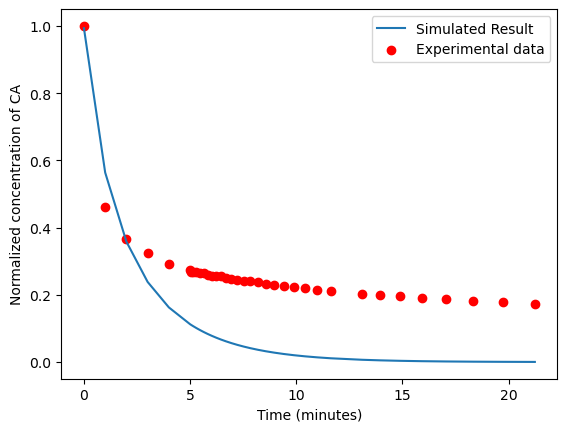

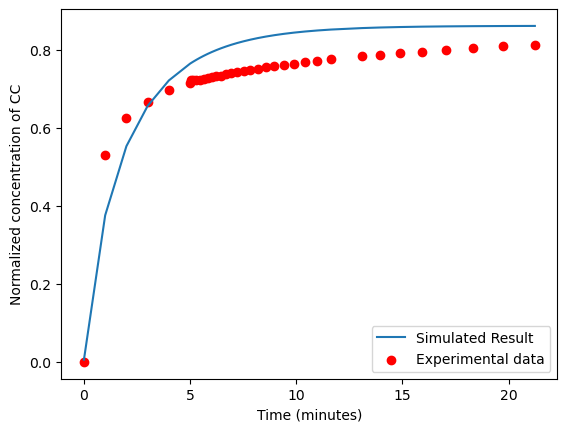

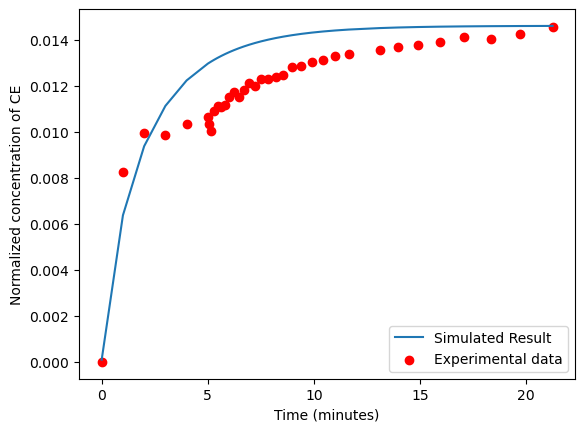

In [8]:
plt.plot(X1,CA_list)
plt.scatter(X1,Y1, color='r')
plt.legend(['Simulated Result','Experimental data'])
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized concentration of CA")
plt.show()
plt.plot(X1,CC_list)
plt.scatter(X1,Y2, color='r')
plt.legend(['Simulated Result','Experimental data'])
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized concentration of CC")
plt.show()
plt.plot(X1,CE_list)
plt.scatter(X1,Y3, color='r')
plt.legend(['Simulated Result','Experimental data'])
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized concentration of CE")
plt.show()

# Collect data from FP model

In [9]:
# Test 1 full stability region

CAo_list = np.linspace(10, 50, 50, endpoint=True)/10
qp_list = np.linspace(325, 325*5, 50, endpoint=True)/1e6

print(CAo_list)
print(qp_list)

CA_output = list()
CC_output = list()
CE_output = list()

CAo_input = list()
qp_input = list()
CA_input = list()
CC_input = list()
CE_input = list()

for CAo in CAo_list:   
    for qp in qp_list:
        CAo_input.append(CAo)
        qp_input.append(qp)
        CA_input.append(1.0)
        CC_input.append(0.0)
        CE_input.append(0.0)
            
        CA_list,CC_list,CE_list = CSimulation(CAo,qp)
        CA_output.append(CA_list)
        CC_output.append(CC_list)
        CE_output.append(CE_list)

[1.         1.08163265 1.16326531 1.24489796 1.32653061 1.40816327
 1.48979592 1.57142857 1.65306122 1.73469388 1.81632653 1.89795918
 1.97959184 2.06122449 2.14285714 2.2244898  2.30612245 2.3877551
 2.46938776 2.55102041 2.63265306 2.71428571 2.79591837 2.87755102
 2.95918367 3.04081633 3.12244898 3.20408163 3.28571429 3.36734694
 3.44897959 3.53061224 3.6122449  3.69387755 3.7755102  3.85714286
 3.93877551 4.02040816 4.10204082 4.18367347 4.26530612 4.34693878
 4.42857143 4.51020408 4.59183673 4.67346939 4.75510204 4.83673469
 4.91836735 5.        ]
[0.000325   0.00035153 0.00037806 0.00040459 0.00043112 0.00045765
 0.00048418 0.00051071 0.00053724 0.00056378 0.00059031 0.00061684
 0.00064337 0.0006699  0.00069643 0.00072296 0.00074949 0.00077602
 0.00080255 0.00082908 0.00085561 0.00088214 0.00090867 0.0009352
 0.00096173 0.00098827 0.0010148  0.00104133 0.00106786 0.00109439
 0.00112092 0.00114745 0.00117398 0.00120051 0.00122704 0.00125357
 0.0012801  0.00130663 0.00133316 0.0013

In [10]:
# collate input for RNN

CAo_input = np.array(CAo_input).reshape(-1,1,1)
qp_input = np.array(qp_input).reshape(-1,1,1)

CA_input = np.array(CA_input).reshape(-1,1,1)
CC_input = np.array(CC_input).reshape(-1,1,1)
CE_input = np.array(CE_input).reshape(-1,1,1)

RNN_input = np.concatenate((CAo_input, qp_input, CA_input, CC_input, CE_input), axis=2) #the value for input variable and the initial value for state variable 

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""
print("RNN_input shape is {}".format(RNN_input.shape))
RNN_input = RNN_input.repeat(36, axis=1)  # to keep consensus with the shape for RNN_output
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (2500, 1, 5)
RNN_input shape is (2500, 36, 5)


In [11]:
# collate output for RNN

CA_output = np.array(CA_output).reshape(-1, 36, 1)
CC_output = np.array(CC_output).reshape(-1, 36, 1)
CE_output = np.array(CE_output).reshape(-1, 36, 1)
RNN_output = np.concatenate((CA_output, CC_output, CE_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (2500, 36, 3)


In [12]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.2, random_state=123)

# define scalers for both X and y base on training data only
scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, 5))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 3))


X_train = scaler_X.transform(X_train.reshape(-1, 5)).reshape(-1,36, 5)
X_test = scaler_X.transform(X_test.reshape(-1, 5)).reshape(-1,36, 5)
y_train = scaler_y.transform(y_train.reshape(-1,3)).reshape(-1,36, 3)
y_test = scaler_y.transform(y_test.reshape(-1,3)).reshape(-1,36, 3)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2000, 36, 5) (500, 36, 5) (2000, 36, 3) (500, 36, 3)


In [13]:
model1 = Sequential()
model1.add(SimpleRNN(16, activation='tanh', return_sequences=True))
model1.add(SimpleRNN(16, activation='tanh', return_sequences=True))
model1.add(Dense(3, activation='linear'))
model1.compile(optimizer='adam', loss='mse', metrics=['mse'])

t0 = time.time()
history = model1.fit(X_train, y_train, epochs=1000, batch_size=256, validation_split=0.25, verbose=2)
t1 = time.time()

Epoch 1/1000
6/6 - 1s - loss: 0.7895 - mse: 0.7895 - val_loss: 0.6963 - val_mse: 0.6963 - 1s/epoch - 203ms/step
Epoch 2/1000
6/6 - 0s - loss: 0.6855 - mse: 0.6855 - val_loss: 0.6792 - val_mse: 0.6792 - 74ms/epoch - 12ms/step
Epoch 3/1000
6/6 - 0s - loss: 0.6676 - mse: 0.6676 - val_loss: 0.6554 - val_mse: 0.6554 - 42ms/epoch - 7ms/step
Epoch 4/1000
6/6 - 0s - loss: 0.6434 - mse: 0.6434 - val_loss: 0.6358 - val_mse: 0.6358 - 50ms/epoch - 8ms/step
Epoch 5/1000
6/6 - 0s - loss: 0.6264 - mse: 0.6264 - val_loss: 0.6176 - val_mse: 0.6176 - 50ms/epoch - 8ms/step
Epoch 6/1000
6/6 - 0s - loss: 0.6064 - mse: 0.6064 - val_loss: 0.5952 - val_mse: 0.5952 - 51ms/epoch - 8ms/step
Epoch 7/1000
6/6 - 0s - loss: 0.5834 - mse: 0.5834 - val_loss: 0.5714 - val_mse: 0.5714 - 50ms/epoch - 8ms/step
Epoch 8/1000
6/6 - 0s - loss: 0.5577 - mse: 0.5577 - val_loss: 0.5424 - val_mse: 0.5424 - 54ms/epoch - 9ms/step
Epoch 9/1000
6/6 - 0s - loss: 0.5283 - mse: 0.5283 - val_loss: 0.5119 - val_mse: 0.5119 - 45ms/epoch - 

In [14]:
#use the test data to evaluate the model
loss_and_metrics = model1.evaluate(X_test, y_test, batch_size=256)
print(loss_and_metrics)

print(t1-t0)

2/2 [==============================] - 0s 6ms/step - loss: 7.6226e-04 - mse: 7.6226e-04
[0.0007622590637765825, 0.0007622590637765825]
55.26819205284119


In [15]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 36, 16)            352       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 36, 16)            528       
                                                                 
 dense (Dense)               (None, 36, 3)             51        
                                                                 
Total params: 931 (3.64 KB)
Trainable params: 931 (3.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# Raw data collected

In [16]:
Y1_list = []
Y2_list = []
Y3_list = []
Input_list = []
for i in range(1,10):
    name = "Sheet" + str(i)
    print(name)
    raw_input = pd.read_excel("C:/Users/vkeerth/Desktop/Updated_photochemical_Experiment.xlsx",name)
    X=raw_input.values.astype(np.float64)
    X1 = X[:,2]
    Y1 = X[:,10]
    Y2 = X[:,11]
    Y3 = X[:,9]
    
    Y1_list.append(Y1)
    Y2_list.append(Y2)
    Y3_list.append(Y3)
    
    Input_list.append([X[0,0],X[0,1],Y1[0],Y2[0],Y3[0]])  #Y1,Y2,Y3 ==1,0,0
    #Input_list.append([X[0,0],X[0,1]])

Sheet1
Sheet2
Sheet3
Sheet4
Sheet5
Sheet6
Sheet7
Sheet8
Sheet9


In [17]:
print(Input_list)
X_input = np.array(Input_list).reshape(-1,1,5)
RNN_input = X_input.repeat(36, axis=1)  # to keep consensus with the shape for RNN_output, since the output variable is collected 100(0.01/1e-4) times for each RNN_input
print("RNN_input shape is {}".format(RNN_input.shape))

[[0.2, 480.0, 1.0, 0.0, 0.0], [0.2, 240.0, 1.0, 0.0, 0.0], [0.2, 120.0, 1.0, 0.0, 0.0], [0.3, 480.0, 1.0, 0.0, 0.0], [0.3, 240.0, 1.0, 0.0, 0.0], [0.3, 120.0, 1.0, 0.0, 0.0], [0.4, 480.0, 1.0, 0.0, 0.0], [0.4, 240.0, 1.0, 0.0, 0.0], [0.4, 120.0, 1.0, 0.0, 0.0]]
RNN_input shape is (9, 36, 5)


In [18]:
Y1_output = np.array(Y1_list)
Y1_output = Y1_output.reshape(-1, 36, 1)
Y2_output = np.array(Y2_list)
Y2_output = Y2_output.reshape(-1, 36, 1)
Y3_output = np.array(Y3_list)
Y3_output = Y3_output.reshape(-1, 36, 1)
print(Y1_output.shape)
RNN_output = np.concatenate((Y1_output, Y2_output, Y3_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

(9, 36, 1)
RNN_output shape is (9, 36, 3)


In [19]:
# split into train and test sets
X_train = RNN_input[:7,:,:]
X_test  = RNN_input[7:,:,:]
y_train = RNN_output[:7,:,:]
y_test =  RNN_output[7:,:,:]
print(X_test[:,1,:])

# define scalers for both X and y base on training data only
scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, 5))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 3))

X_train = scaler_X.transform(X_train.reshape(-1, 5)).reshape(-1,36, 5)
X_test = scaler_X.transform(X_test.reshape(-1, 5)).reshape(-1,36, 5)
y_train = scaler_y.transform(y_train.reshape(-1,3)).reshape(-1,36, 3)
y_test = scaler_y.transform(y_test.reshape(-1,3)).reshape(-1,36, 3)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

[[  0.4 240.    1.    0.    0. ]
 [  0.4 120.    1.    0.    0. ]]
(7, 36, 5) (2, 36, 5) (7, 36, 3) (2, 36, 3)


In [20]:
# Standard RNN Model for Comparison

model2 = Sequential()
model2.add(SimpleRNN(4, activation='tanh', return_sequences=True))
model2.add(Dense(3, activation='linear'))
model2.compile(optimizer='adam', loss='mse', metrics=['mse'])

t0 = time.time()
history = model2.fit(X_train, y_train, epochs=200, batch_size=256, validation_split=0.25, verbose=2)
t1 = time.time()

Epoch 1/200
1/1 - 1s - loss: 1.1556 - mse: 1.1556 - val_loss: 1.0166 - val_mse: 1.0166 - 684ms/epoch - 684ms/step
Epoch 2/200
1/1 - 0s - loss: 1.1521 - mse: 1.1521 - val_loss: 1.0171 - val_mse: 1.0171 - 31ms/epoch - 31ms/step
Epoch 3/200
1/1 - 0s - loss: 1.1487 - mse: 1.1487 - val_loss: 1.0173 - val_mse: 1.0173 - 25ms/epoch - 25ms/step
Epoch 4/200
1/1 - 0s - loss: 1.1453 - mse: 1.1453 - val_loss: 1.0175 - val_mse: 1.0175 - 19ms/epoch - 19ms/step
Epoch 5/200
1/1 - 0s - loss: 1.1420 - mse: 1.1420 - val_loss: 1.0176 - val_mse: 1.0176 - 16ms/epoch - 16ms/step
Epoch 6/200
1/1 - 0s - loss: 1.1388 - mse: 1.1388 - val_loss: 1.0176 - val_mse: 1.0176 - 19ms/epoch - 19ms/step
Epoch 7/200
1/1 - 0s - loss: 1.1356 - mse: 1.1356 - val_loss: 1.0175 - val_mse: 1.0175 - 31ms/epoch - 31ms/step
Epoch 8/200
1/1 - 0s - loss: 1.1324 - mse: 1.1324 - val_loss: 1.0174 - val_mse: 1.0174 - 16ms/epoch - 16ms/step
Epoch 9/200
1/1 - 0s - loss: 1.1293 - mse: 1.1293 - val_loss: 1.0172 - val_mse: 1.0172 - 31ms/epoch - 

# Test and training error of the standard RNN model

In [21]:
#use the test data to evaluate the model
loss_and_metrics = model2.evaluate(X_test, y_test, batch_size=256)
print(loss_and_metrics)
loss_and_metrics = model2.evaluate(X_train, y_train, batch_size=256)
print(loss_and_metrics)

print(t1-t0)
model2.save('model_stand_7.h5')

1/1 [==============================] - 0s 16ms/step - loss: 1.0407 - mse: 1.0407
[1.0407085418701172, 1.0407085418701172]
1/1 [==============================] - 0s 17ms/step - loss: 0.8603 - mse: 0.8603
[0.8602917790412903, 0.8602917790412903]
5.534717798233032


c:\Users\vkeerth\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Transfer learning

In [22]:
#use the test data to evaluate the model
loss_and_metrics = model1.evaluate(X_test, y_test, batch_size=256)
print(loss_and_metrics)

1/1 [==============================] - 0s 22ms/step - loss: 0.2837 - mse: 0.2837
[0.2837221920490265, 0.2837221920490265]


In [23]:
t0 = time.time()
history = model1.fit(X_train, y_train, epochs=200, batch_size=256, validation_split=0.25, verbose=2)
t1 = time.time()

Epoch 1/200
1/1 - 0s - loss: 0.2088 - mse: 0.2088 - val_loss: 0.3655 - val_mse: 0.3655 - 44ms/epoch - 44ms/step
Epoch 2/200
1/1 - 0s - loss: 0.2258 - mse: 0.2258 - val_loss: 0.3521 - val_mse: 0.3521 - 22ms/epoch - 22ms/step
Epoch 3/200
1/1 - 0s - loss: 0.1880 - mse: 0.1880 - val_loss: 0.3036 - val_mse: 0.3036 - 22ms/epoch - 22ms/step
Epoch 4/200
1/1 - 0s - loss: 0.1801 - mse: 0.1801 - val_loss: 0.2694 - val_mse: 0.2694 - 16ms/epoch - 16ms/step
Epoch 5/200
1/1 - 0s - loss: 0.1989 - mse: 0.1989 - val_loss: 0.2422 - val_mse: 0.2422 - 31ms/epoch - 31ms/step
Epoch 6/200
1/1 - 0s - loss: 0.1749 - mse: 0.1749 - val_loss: 0.2276 - val_mse: 0.2276 - 16ms/epoch - 16ms/step
Epoch 7/200
1/1 - 0s - loss: 0.1617 - mse: 0.1617 - val_loss: 0.2237 - val_mse: 0.2237 - 22ms/epoch - 22ms/step
Epoch 8/200
1/1 - 0s - loss: 0.1770 - mse: 0.1770 - val_loss: 0.2214 - val_mse: 0.2214 - 16ms/epoch - 16ms/step
Epoch 9/200
1/1 - 0s - loss: 0.1829 - mse: 0.1829 - val_loss: 0.2198 - val_mse: 0.2198 - 33ms/epoch - 33

# Test and training error of the TL RNN model

In [24]:
#use the test data to evaluate the model
loss_and_metrics = model1.evaluate(X_test, y_test, batch_size=256)
print(loss_and_metrics)
loss_and_metrics = model1.evaluate(X_train, y_train, batch_size=256)
print(loss_and_metrics)

print(t1-t0)

model1.save('model_TL_7.h5')

1/1 [==============================] - 0s 16ms/step - loss: 0.0706 - mse: 0.0706
[0.07063852250576019, 0.07063852250576019]
1/1 [==============================] - 0s 21ms/step - loss: 0.0509 - mse: 0.0509
[0.050884924829006195, 0.050884924829006195]
5.285732269287109


# Checking and Plotting Solution

In [25]:
RNN_predictT = model1.predict(X_test)
RNN_predictT = scaler_y.inverse_transform(RNN_predictT.reshape(-1,3)).reshape(-1,36, 3)

RNN_predict = model2.predict(X_test)
RNN_predict = scaler_y.inverse_transform(RNN_predict.reshape(-1,3)).reshape(-1,36, 3)
print(RNN_predict.shape)
Y_real = scaler_y.inverse_transform(y_test.reshape(-1,3)).reshape(-1,36, 3)

1/1 [==============================] - 0s 84ms/step
(2, 36, 3)


The condition:  -2


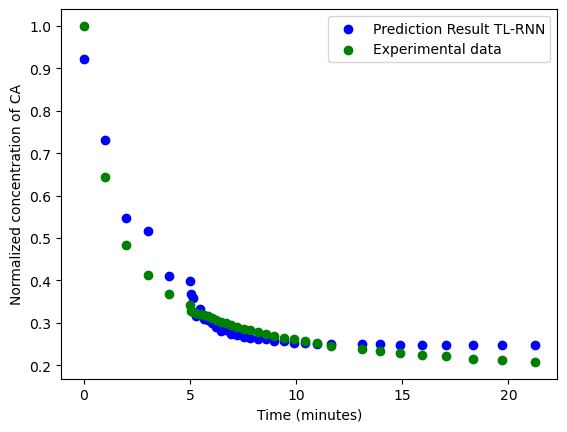

The condition:  -2


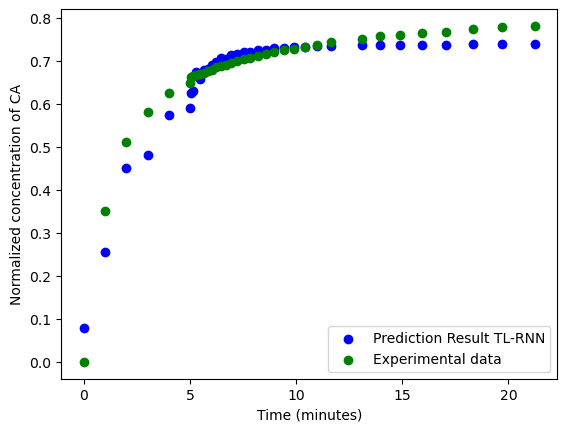

The condition:  -2


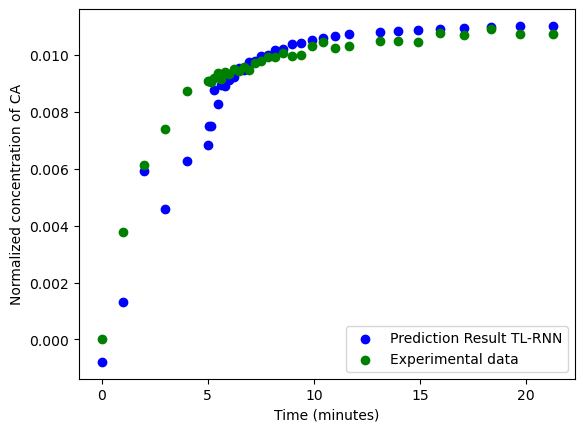

The condition:  -1


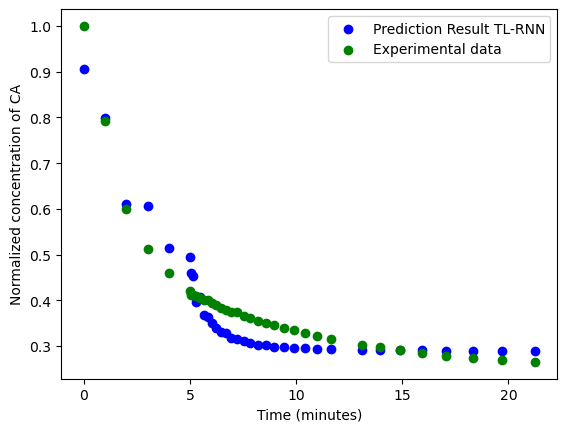

The condition:  -1


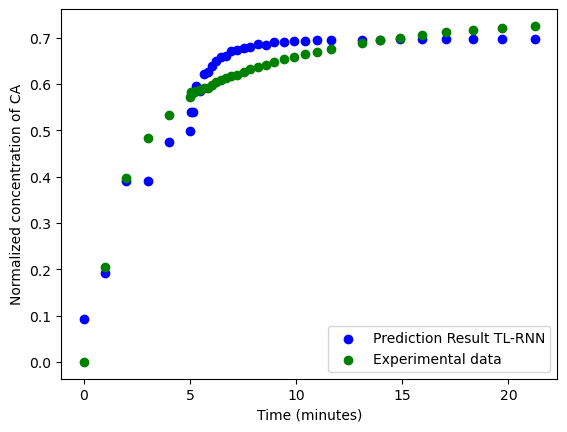

The condition:  -1


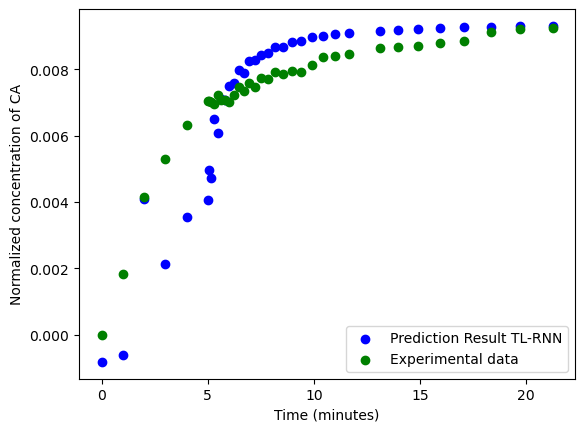

In [26]:
for j in range(2):
    j = j-2
    for i in range(3):
        print("The condition: ",j)
        Y_iT = np.array(RNN_predictT[j,:,i]).reshape(-1)
        Y_real_i = np.array(Y_real[j,:,i]).reshape(-1)
        plt.scatter(X1,Y_iT, color='b')
        plt.scatter(X1,Y_real_i, color='g')
        plt.legend(['Prediction Result TL-RNN','Experimental data'])
        plt.xlabel("Time (minutes)")
        plt.ylabel("Normalized concentration of CA")
        plt.show()